<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

Test what is the decoding change for single size training 

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


# FULL MODEL

## Packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML

import POMDPgame_bars
from POMDPgame_bars import*

import POMDPgame_basic
from POMDPgame_basic import*

import POMDPgame_holes
from POMDPgame_holes import*


import RNN
from RNN import *

import navigation2
from navigation2 import*

import Nets
from Nets import*

%matplotlib inline

### Qnetwork

To select actions we take maximum of Q value, corresponding to certain move.

For the liquid state approach to work, you need a lot of neurons as surplus or enough hidden to hidden connectivity to make it have an effect.

##  POMDP RNN Game

In this game , we use a new reward function determined by game, if the agent achieves the goal before 50, reward is 1. If time pass 50 reward is 0.5, once time pass 100 agent gets a reward of -0.5 .  Practically, this is found to be easier to learn than the rewards as a continous function of time.  Tf the agent learns to search in a efficient way, the largest possible way for search is to firstly arrive at corner then goes to the goal, which, takes about 50 steps, it is reasonble to make 50 and 100 as milestone thing.  Also in principe as the game doesn't have a timer , it is not if it can use a reward as funtion of time

3 condition for ending , when pass time limit, game over

For weight update, it seems to be better do it after episode, as it makes non-sense evaluate strategy during episode, but a the end. Also, it is much quicker. 

A programming of MDP here, hidden state is as state of enviroment

task <class 'POMDPgame_basic.GameBasic'>
task <class 'POMDPgame_holes.GameHole'>
task <class 'POMDPgame_bars.GameBar'>
task <class 'POMDPgame_scale.GameScale'>
task <class 'POMDPgame_scale_x.GameScale_x'>
task <class 'POMDPgame_scale_y.GameScale_y'>
task <class 'POMDPgame_implicit.GameImplicit'>


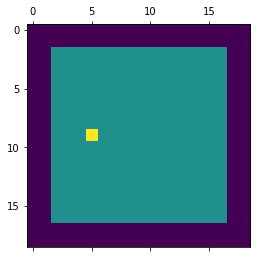

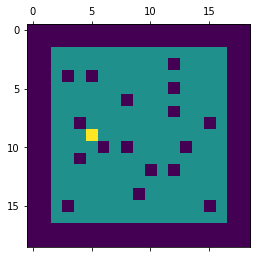

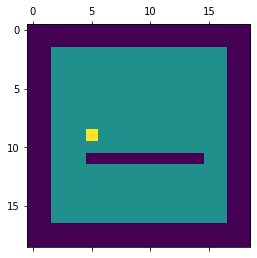

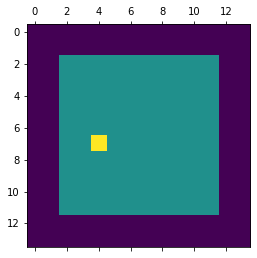

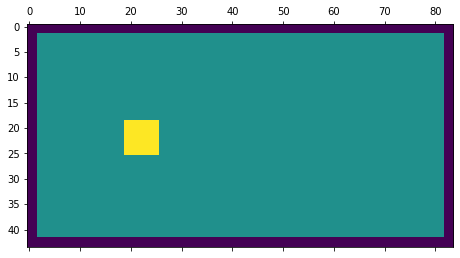

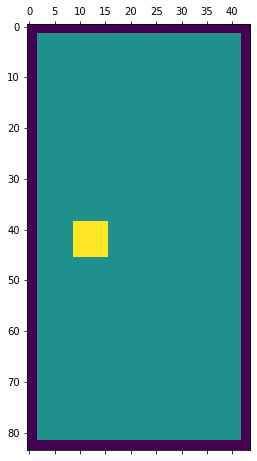

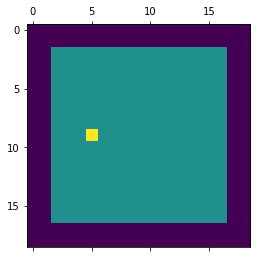

In [3]:
basicgame = CreateGame(GameBasic, holes = 0)
basicgame.reset(size = 15, reward_control=0)
plt.matshow(basicgame.grid.grid)

holegame = CreateGame(GameHole, holes = 50)
holegame.reset(size = 15, reward_control=0)
plt.matshow(holegame.grid.grid)

bargame = CreateGame(GameBar, holes = 0)
bargame.reset(size = 15, reward_control=0)
plt.matshow(bargame.grid.grid)

scalegame = CreateGame(GameScale, holes = 0)
scalegame.reset(reward_control=0)
plt.matshow(scalegame.grid.grid)

scalegame_x = CreateGame(GameScale_x, holes = 0)
scalegame_x.reset(reward_control=0)
plt.matshow(scalegame_x.grid.grid)

scalegame_y = CreateGame(GameScale_y, holes = 0)
scalegame_y.reset(reward_control=0)
plt.matshow(scalegame_y.grid.grid)

Imp_game = CreateGame(GameImplicit, holes = 0)
Imp_game.reset(size = 15, reward_control=0)
plt.matshow(Imp_game.grid.grid)

Think of how to make this traning stable, adding exploration noise , intenral noise or environmental variability like multiple mazes  

In [4]:
# moving bar train, noise = 0.0
trial = 300
tasks = ['basic', 'hole', 'bar', 'scale', 'scale_x', 'scale_y', 'implicit']
episodes = [10, 30, 30, 10, 30, 30, 30]
# iterations = [1, 1, 1, 1, 1, 1, 1]
for n, task in zip(episodes, tasks):
        Task =  MultipleTasks(task = task, weight_write = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)\
                              , noise = 0.0)
        weight_read = Task.weight
        weight_write = 'weights_' + task + '/rnn_1515tanh512_checkpoint{}'.format(trial)
        if task == 'scale':
            size_train = np.arange(10, 51, 10)
        else:
            size_train = [15]
        if (task == 'hole') or (task == 'bar'):
            iterations = 5
            epochs = 100
        else:
            iterations = 50
            epochs = 10
        print ('start', size_train)
        Task.qlearn(task, weight_read,  weight_write, episodes = n, noise = 0, size_train = size_train, size_test=[15], iterations = iterations
                   , epochs = epochs)

basic
start [15]


/home/tie/.conda/envs/torch/lib/python3.7/site-packages/torch/tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


clear session data 49 1164693504
basic performance 0.3574504777629778
clear session data 49 1159069696
basic performance 0.7418229123307248
clear session data 49 1159340032
basic performance 0.7819428618256743
clear session data 49 1159610368
basic performance 0.8126098510864137
clear session data 49 1159610368
basic performance 0.6665068872100122
clear session data 49 1159610368
basic performance 0.705687108030858
clear session data 49 1159610368
basic performance 0.7195238572191697
clear session data 49 1159610368
basic performance 0.737269111097236
clear session data 49 1159880704
basic performance 0.7787082492160617
clear session data 49 1159880704
basic performance 0.8528817103035853
hole
start [15]
clear session data 4 9221144576
hole performance -0.581898424207167
clear session data 4 9582415872
hole performance -0.5031094716391317
clear session data 4 9581821952
hole performance -0.41596869635704947
clear session data 4 9586151424
hole performance -0.34663744257173656
clear ses

In [ ]:
# moving bar train, noise = 0.0
trial = 300
tasks = [ 'bar']
episodes = [30]
# iterations = [1, 1, 1, 1, 1, 1, 1]
for n, task in zip(episodes, tasks):
        Task =  MultipleTasks(task = task, weight_write = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)\
                              , noise = 0.0)
        weight_read = Task.weight
        weight_write = 'weights_' + task + '/rnn_1515tanh512_checkpoint{}'.format(trial)
        if task == 'scale':
            size_train = np.arange(10, 51, 10)
        else:
            size_train = [15]
        if (task == 'hole') or (task == 'bar'):
            iterations = 5
            epochs = 100
        else:
            iterations = 50
            epochs = 10
        print ('start', size_train)
        Task.qlearn(task, weight_read,  weight_write, episodes = n, noise = 0, size_train = size_train, size_test=[15], iterations = iterations
                   , epochs = epochs)

task <class 'POMDPgame_bars.GameBar'>
bar
start [15]


/home/tie/.conda/envs/torch/lib/python3.7/site-packages/torch/tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


clear session data 4 8967696384
bar performance -0.7106830556219144
clear session data 4 9375588352
bar performance -0.625
clear session data 4 9662603264
bar performance -0.4891030844155845
clear session data 4 9663340544
bar performance -0.38822279851374675
clear session data 4 9590251520
bar performance -0.3536973443223443
clear session data 4 9589633024
bar performance -0.42406116742054245
clear session data 4 9590087680
bar performance -0.19311191304842917
clear session data 4 9589981184
bar performance -0.20116281288156293
clear session data 4 9590439936
bar performance -0.25242127664002667
clear session data 4 9590878208
bar performance -0.1902645097957598
clear session data 4 9590267904
bar performance -0.1977807782495282
clear session data 4 9590452224
bar performance -0.41302872474747476
clear session data 4 9590628352
bar performance -0.35622281364468866


### measure decoding 

Decoding accuracy decreases, there are two possible reasons: 
1, decoding has bias,  information of position is only refleted by decoding, if there is certain bias , it is not trustable
2, it is the real measure of information, so there are less spatial information about space, or an effect decoupling/disentanglement of position. This can be due the network succeed at finding an even lower diemnsion object which gives successful performance.  The representation deceases its information to input in a sense. 

This can be linked to receptive field by looking at how space is represented. 